In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
# import crossval_score
from sklearn.model_selection import cross_val_score, RepeatedKFold
from feature_importance import FeatureImportance


import matplotlib.pyplot as plt

import pandas as pd

In [ ]:
df = pd.read_csv('train.csv')
X_train, X_test, y_train, y_test = train_test_split(df.drop('loan_status', axis=1), df['loan_status'], test_size=0.2, random_state=42)

X_train = X_train.drop('id', axis=1)
X_train

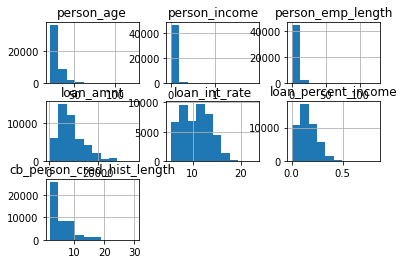

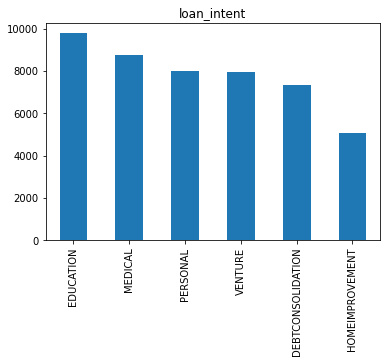

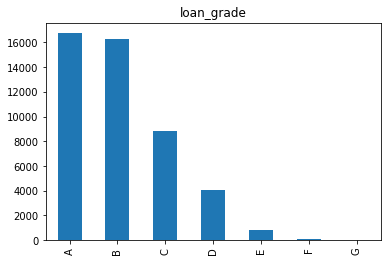

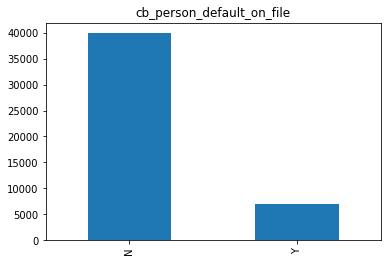

In [51]:
categorical_features = X_train.select_dtypes(include=['object']).columns
numeric_features = X_train.select_dtypes(exclude=['object']).columns

#gneerate graphs of the categorical features
X_train.hist()
for col in categorical_features:
    X_train[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.show()
    


In [57]:


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Add a name for the preprocessor step
    ('classifier', RandomForestClassifier())
])

rkf = RepeatedKFold(n_splits=2, n_repeats=3, random_state=1)


pipe.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier())])

In [58]:
cross_val_score(pipe, X_train, y_train, cv=rkf, scoring='accuracy')


array([0.9493563 , 0.95072044, 0.94939893, 0.95097621, 0.94939893,
       0.94888737])

In [ ]:
# predict the test data
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
# 


              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10087
           1       0.92      0.72      0.81      1642

    accuracy                           0.95     11729
   macro avg       0.94      0.86      0.89     11729
weighted avg       0.95      0.95      0.95     11729

0.9525961292522807


<BarContainer object of 26 artists>

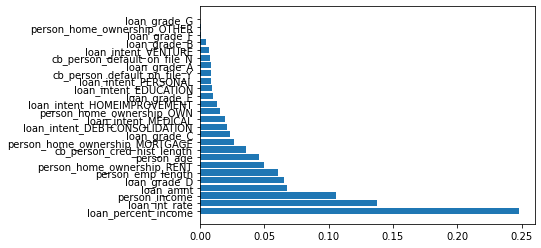

In [63]:
feature_importances = pipe.named_steps['classifier'].feature_importances_
# Get feature names
numeric_feature_names = numeric_features.tolist()
categorical_feature_names = pipe.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
feature_names = numeric_feature_names + categorical_feature_names

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
# plot the feature importance
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])